# Configuration

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
sampling_rate = 100
dataset_path = "ecg_dataset/"

# Preparing data for training

In [3]:
from scripts.data_preparation import get_data_ready_for_training

(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    multi_label_binarizer,
) = get_data_ready_for_training(
    dataset_path=dataset_path,
    sampling_rate=100,
    use_tsfel=True,
    use_temporal_features=True,
    scale_features=True,
    train_val_split=False,
)

Loaded labels
Loaded ECG signals
Encoded labels
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
Extracted features
Scaled ECG signals


# Binary Relevance

## SVC

### Hyperparameter selection

In [8]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc_parameters = [
    {
        "classifier": [SVC()],
        "classifier__kernel": ["rbf", "linear"],
        "classifier__C": [0.01, 0.1, 1],
    }
]

svc_binary_relevance_classifier_cv = GridSearchCV(
    BinaryRelevance(),
    svc_parameters,
    verbose=2,
    scoring="accuracy",
    error_score="raise",
)

### Model training

In [9]:
svc_binary_relevance_classifier_cv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=rbf; total time=  44.4s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=rbf; total time=  44.6s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=rbf; total time=  45.5s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=rbf; total time=  43.9s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=rbf; total time=  42.5s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear; total time=  28.2s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear; total time=  29.1s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear; total time=  28.8s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear; total time=  28.4s
[CV] END classifier=SVC(), classifier__C=0.01, classifier__kernel=linear; total time=  28.1s
[CV] END classifier=SVC()

GridSearchCV(error_score='raise',
             estimator=BinaryRelevance(require_dense=[True, True]),
             param_grid=[{'classifier': [SVC(C=1)],
                          'classifier__C': [0.01, 0.1, 1],
                          'classifier__kernel': ['rbf', 'linear']}],
             scoring='accuracy', verbose=2)

In [46]:
svc_binary_relevance_classifier_cv.best_params_

{'classifier': SVC(C=1), 'classifier__C': 1, 'classifier__kernel': 'rbf'}

In [48]:
best_svc_with_probability = BinaryRelevance(
    classifier=SVC(C=1.0, kernel="rbf", probability=True), require_dense=[False, True]
)

best_svc_with_probability.fit(X_train, y_train)

BinaryRelevance(classifier=SVC(probability=True), require_dense=[False, True])

### Model saving

In [49]:
import os
from joblib import dump

svc_model = best_svc_with_probability
svc_model_filename = "svc.joblib"
output_directory = f"saved_models/svc/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

svc_model_path = os.path.join(output_directory, svc_model_filename)

dump(
    value=svc_model,
    filename=svc_model_path,
)

['saved_models/svc/svc.joblib']

## Model loading

In [4]:
from joblib import load

svc_model = load("saved_models/svc/svc.joblib")

### Model evaluation

In [5]:
y_pred_proba = svc_model.predict_proba(X_test).toarray()

## Optimal thresholds

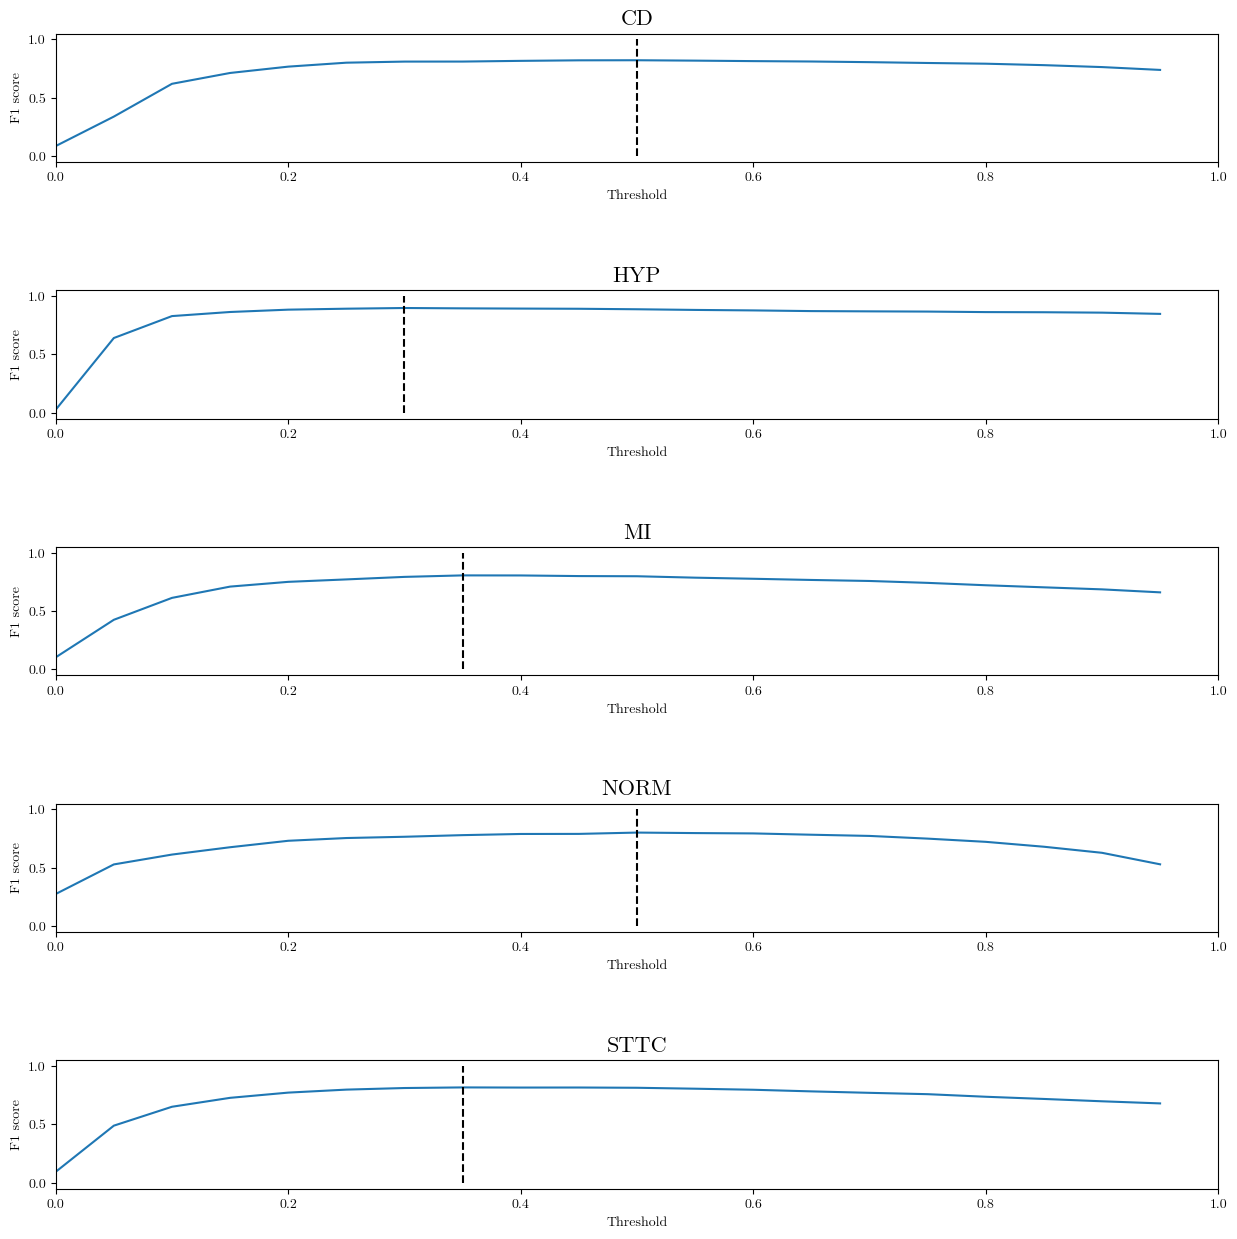

In [6]:
from scripts.data_evaluation import plot_optimal_thresholds

optimal_thresholds = plot_optimal_thresholds(
    y_test, y_pred_proba, directory_name="svc", save_plot=True
)

In [7]:
from scripts.data_evaluation import generate_model_evaluation

generate_model_evaluation(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    y_pred_proba=y_pred_proba,
    directory_name="svc",
    file_name="model_evaluation.csv",
    save_data=True,
)

,loss,binary_accuracy,recall,precision,auc
0,0.377,0.838,0.551,0.758,0.709


In [8]:
from scripts.data_evaluation import generate_model_evaluation

generate_model_evaluation(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    y_pred_proba=y_pred_proba,
    directory_name="svc",
    file_name="model_evaluation_optimized.csv",
    save_data=True,
)

,loss,binary_accuracy,recall,precision,auc
0,0.377,0.833,0.636,0.695,0.743


## Confusion matrix

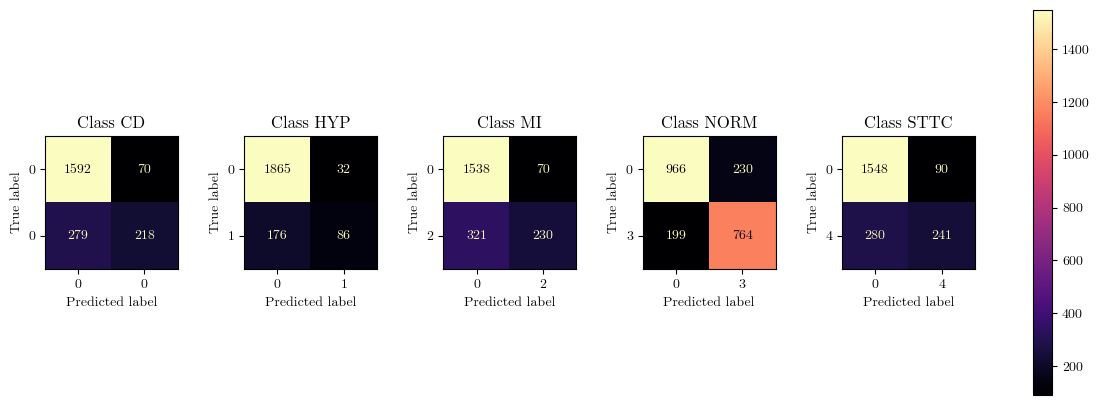

In [9]:
from scripts.data_evaluation import plot_confusion_matrix

plot_confusion_matrix(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    class_names=multi_label_binarizer.classes_,
    directory_name="svc",
    file_name="confusion_matrix.png",
    save_plot=True,
)

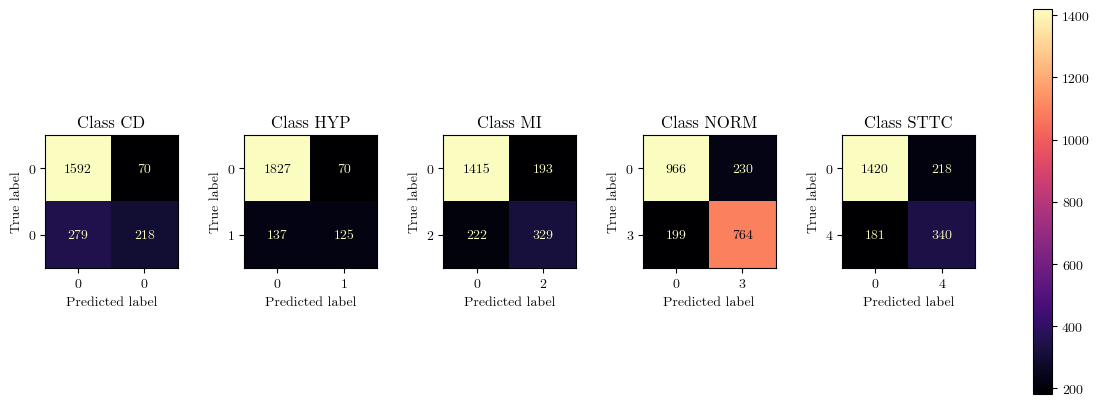

In [10]:
from scripts.data_evaluation import plot_confusion_matrix

plot_confusion_matrix(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    class_names=multi_label_binarizer.classes_,
    directory_name="svc",
    file_name="confusion_matrix_optimized.png",
    save_plot=True,
)

## Classification report

In [11]:
from scripts.data_evaluation import generate_classification_report

generate_classification_report(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    class_names=list(multi_label_binarizer.classes_),
    directory_name="svc",
    file_name="classification_report.csv",
    save_data=True,
)

,precision,recall,f1-score,support
CD,0.757,0.439,0.555,497.0
HYP,0.729,0.328,0.453,262.0
MI,0.767,0.417,0.541,551.0
NORM,0.769,0.793,0.781,963.0
STTC,0.728,0.463,0.566,521.0
micro avg,0.758,0.551,0.638,2794.0
macro avg,0.750,0.488,0.579,2794.0
weighted avg,0.755,0.551,0.622,2794.0
samples avg,0.606,0.577,0.578,2794.0


In [12]:
from scripts.data_evaluation import generate_classification_report

generate_classification_report(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    class_names=list(multi_label_binarizer.classes_),
    directory_name="svc",
    file_name="classification_report_optimized.csv",
    save_data=True,
)

,precision,recall,f1-score,support
CD,0.757,0.439,0.555,497.0
HYP,0.641,0.477,0.547,262.0
MI,0.630,0.597,0.613,551.0
NORM,0.769,0.793,0.781,963.0
STTC,0.609,0.653,0.630,521.0
micro avg,0.695,0.636,0.664,2794.0
macro avg,0.681,0.592,0.625,2794.0
weighted avg,0.698,0.636,0.658,2794.0
samples avg,0.636,0.650,0.626,2794.0


## Show predictions on sample patients

In [13]:
import pandas as pd
import numpy as np

number_of_patients = 15

sample_patients_predictions_df = pd.DataFrame()

for index in range(number_of_patients):
    patient_ecg = np.expand_dims(X_test[index], axis=0)
    patient_ecg_prob = (svc_model.predict_proba(patient_ecg).toarray() > 0.5) * 1
    sample_patients_predictions_df = pd.concat(
        [
            sample_patients_predictions_df,
            pd.DataFrame(
                data={
                    "Predicted": np.squeeze(patient_ecg_prob),
                    "True": y_test[index],
                    "---------": np.array(["-" for x in range(5)]),
                },
                index=list(multi_label_binarizer.classes_),
            ).transpose(),
        ]
    )

sample_patients_predictions_df.to_csv(f"saved_data/svc/sample_patients_predictions.csv")

sample_patients_predictions_df

,CD,HYP,MI,NORM,STTC
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,0,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0


In [14]:
import pandas as pd
import numpy as np

number_of_patients = 15

sample_patients_predictions_df = pd.DataFrame()

for index in range(number_of_patients):
    patient_ecg = np.expand_dims(X_test[index], axis=0)
    patient_ecg_prob = (
        svc_model.predict_proba(patient_ecg).toarray() > optimal_thresholds
    ) * 1
    sample_patients_predictions_df = pd.concat(
        [
            sample_patients_predictions_df,
            pd.DataFrame(
                data={
                    "Predicted": np.squeeze(patient_ecg_prob),
                    "True": y_test[index],
                    "---------": np.array(["-" for x in range(5)]),
                },
                index=list(multi_label_binarizer.classes_),
            ).transpose(),
        ]
    )

sample_patients_predictions_df.to_csv(
    f"saved_data/svc/sample_patients_predictions_optimized.csv"
)

sample_patients_predictions_df

,CD,HYP,MI,NORM,STTC
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,0,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0


## Decision Tree

### Hyperparameter selection

In [30]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_parameters = [
    {
        "classifier": [DecisionTreeClassifier()],
        "classifier__criterion": ["gini", "entropy"],
        "classifier__max_depth": [3, 5, 10, 15],
    }
]

decision_tree_binary_relevance_classifier_cv = GridSearchCV(
    BinaryRelevance(),
    decision_tree_parameters,
    verbose=2,
    scoring="accuracy",
    error_score="raise",
)

## Model training

In [31]:
decision_tree_binary_relevance_classifier_cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=3; total time=   1.8s
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=3; total time=   1.8s
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=3; total time=   1.8s
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=3; total time=   1.8s
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=3; total time=   1.8s
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=5; total time=   2.9s
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=5; total time=   2.9s
[CV] END classifier=DecisionTreeClassifier(), classifier__criterion=gini, classifier__max_depth=5; total time=   2

GridSearchCV(error_score='raise',
             estimator=BinaryRelevance(require_dense=[True, True]),
             param_grid=[{'classifier': [DecisionTreeClassifier(max_depth=5)],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__max_depth': [3, 5, 10, 15]}],
             scoring='accuracy', verbose=2)

In [42]:
decision_tree_binary_relevance_classifier_cv.best_params_

{'classifier': DecisionTreeClassifier(max_depth=5),
 'classifier__criterion': 'gini',
 'classifier__max_depth': 5}

### Model saving

In [33]:
import os
from joblib import dump

decision_tree_model = decision_tree_binary_relevance_classifier_cv.best_estimator_
decision_tree_model_filename = "decision_tree.joblib"
output_directory = f"saved_models/decision_tree/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

decision_tree_model_path = os.path.join(output_directory, decision_tree_model_filename)

dump(
    value=decision_tree_model,
    filename=decision_tree_model_path,
)

['saved_models/decision_tree/decision_tree.joblib']

## Model loading

In [15]:
from joblib import load

decision_tree_model = load("saved_models/decision_tree/decision_tree.joblib")

### Model evaluation

In [16]:
y_pred_proba = decision_tree_model.predict_proba(X_test).toarray()

## Optimal thresholds

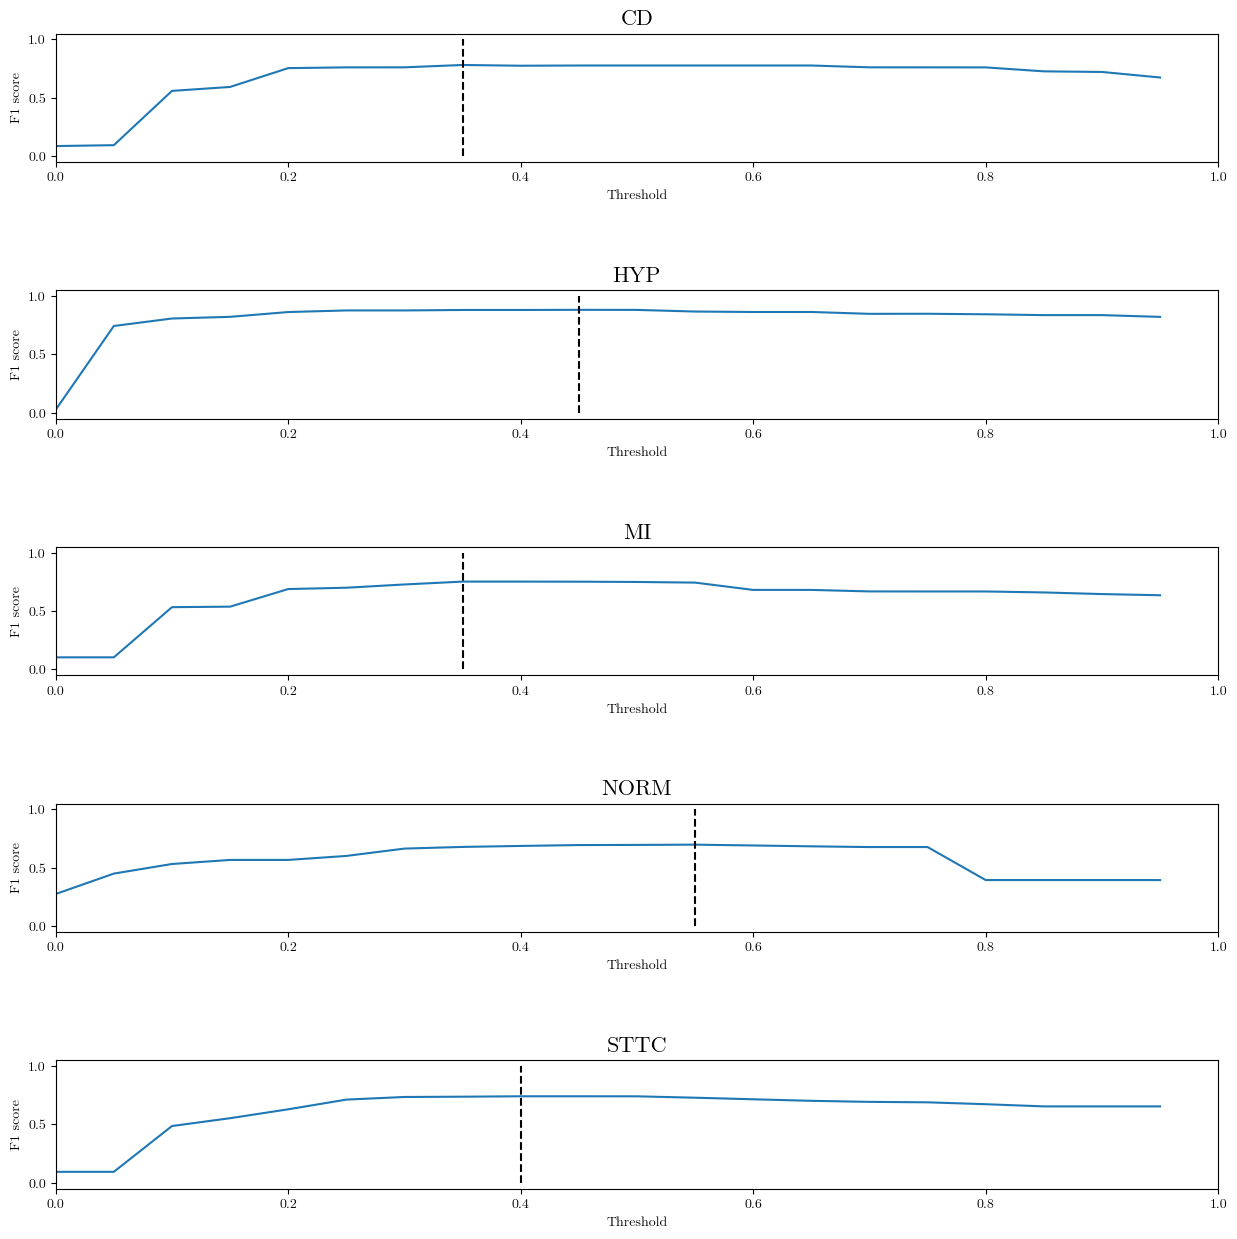

In [17]:
from scripts.data_evaluation import plot_optimal_thresholds

optimal_thresholds = plot_optimal_thresholds(
    y_test, y_pred_proba, directory_name="decision_tree", save_plot=True
)

In [19]:
from scripts.data_evaluation import generate_model_evaluation

generate_model_evaluation(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    y_pred_proba=y_pred_proba,
    directory_name="decision_tree",
    file_name="model_evaluation.csv",
    save_data=True,
)

,loss,binary_accuracy,recall,precision,auc
0,0.469,0.788,0.443,0.628,0.644


In [20]:
from scripts.data_evaluation import generate_model_evaluation

generate_model_evaluation(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    y_pred_proba=y_pred_proba,
    directory_name="decision_tree",
    file_name="model_evaluation_optimized.csv",
    save_data=True,
)

,loss,binary_accuracy,recall,precision,auc
0,0.469,0.782,0.49,0.595,0.659


## Confusion matrix

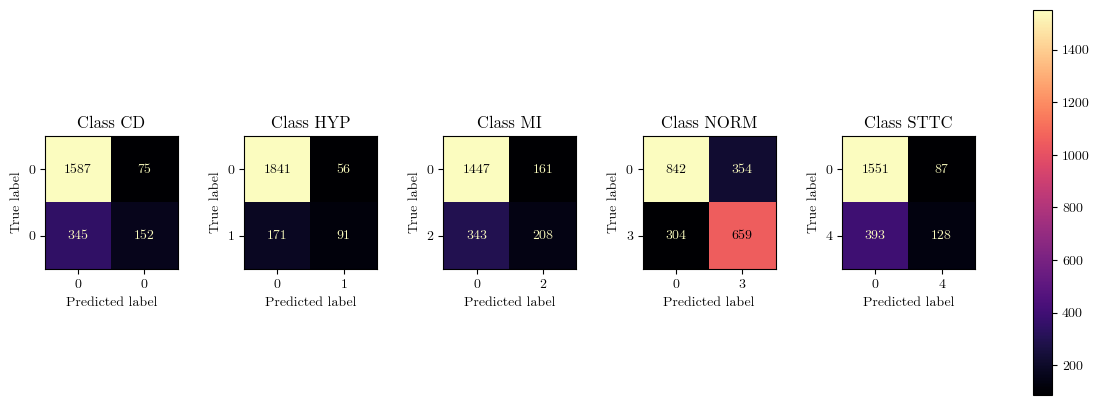

In [21]:
from scripts.data_evaluation import plot_confusion_matrix

plot_confusion_matrix(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    class_names=multi_label_binarizer.classes_,
    directory_name="decision_tree",
    file_name="confusion_matrix.png",
    save_plot=True,
)

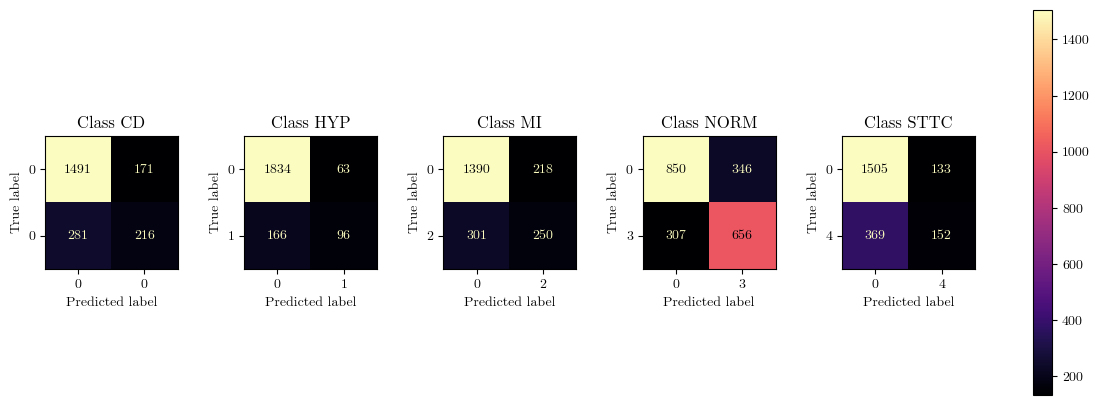

In [26]:
from scripts.data_evaluation import plot_confusion_matrix

plot_confusion_matrix(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    class_names=multi_label_binarizer.classes_,
    directory_name="decision_tree",
    file_name="confusion_matrix_optimized.png",
    save_plot=True,
)

## Classification report

In [27]:
from scripts.data_evaluation import generate_classification_report

generate_classification_report(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    class_names=list(multi_label_binarizer.classes_),
    directory_name="decision_tree",
    file_name="classification_report.csv",
    save_data=True,
)

,precision,recall,f1-score,support
CD,0.670,0.306,0.420,497.0
HYP,0.619,0.347,0.445,262.0
MI,0.564,0.377,0.452,551.0
NORM,0.651,0.684,0.667,963.0
STTC,0.595,0.246,0.348,521.0
micro avg,0.628,0.443,0.520,2794.0
macro avg,0.620,0.392,0.466,2794.0
weighted avg,0.624,0.443,0.500,2794.0
samples avg,0.474,0.471,0.457,2794.0


In [28]:
from scripts.data_evaluation import generate_classification_report

generate_classification_report(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    class_names=list(multi_label_binarizer.classes_),
    directory_name="decision_tree",
    file_name="classification_report_optimized.csv",
    save_data=True,
)

,precision,recall,f1-score,support
CD,0.558,0.435,0.489,497.0
HYP,0.604,0.366,0.456,262.0
MI,0.534,0.454,0.491,551.0
NORM,0.655,0.681,0.668,963.0
STTC,0.533,0.292,0.377,521.0
micro avg,0.595,0.490,0.538,2794.0
macro avg,0.577,0.446,0.496,2794.0
weighted avg,0.586,0.490,0.527,2794.0
samples avg,0.491,0.509,0.483,2794.0


## Show predictions on sample patients

In [29]:
import pandas as pd
import numpy as np

number_of_patients = 15

sample_patients_predictions_df = pd.DataFrame()

for index in range(number_of_patients):
    patient_ecg = np.expand_dims(X_test[index], axis=0)
    patient_ecg_prob = (
        decision_tree_model.predict_proba(patient_ecg).toarray() > 0.5
    ) * 1
    sample_patients_predictions_df = pd.concat(
        [
            sample_patients_predictions_df,
            pd.DataFrame(
                data={
                    "Predicted": np.squeeze(patient_ecg_prob),
                    "True": y_test[index],
                    "---------": np.array(["-" for x in range(5)]),
                },
                index=list(multi_label_binarizer.classes_),
            ).transpose(),
        ]
    )

sample_patients_predictions_df.to_csv(
    f"saved_data/decision_tree/sample_patients_predictions.csv"
)

sample_patients_predictions_df

,CD,HYP,MI,NORM,STTC
Predicted,0,0,1,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,0,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0


In [30]:
import pandas as pd
import numpy as np

number_of_patients = 15

sample_patients_predictions_df = pd.DataFrame()

for index in range(number_of_patients):
    patient_ecg = np.expand_dims(X_test[index], axis=0)
    patient_ecg_prob = (
        decision_tree_model.predict_proba(patient_ecg).toarray() > optimal_thresholds
    ) * 1
    sample_patients_predictions_df = pd.concat(
        [
            sample_patients_predictions_df,
            pd.DataFrame(
                data={
                    "Predicted": np.squeeze(patient_ecg_prob),
                    "True": y_test[index],
                    "---------": np.array(["-" for x in range(5)]),
                },
                index=list(multi_label_binarizer.classes_),
            ).transpose(),
        ]
    )

sample_patients_predictions_df.to_csv(
    f"saved_data/decision_tree/sample_patients_predictions_optimized.csv"
)

sample_patients_predictions_df

,CD,HYP,MI,NORM,STTC
Predicted,0,0,1,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,0,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0


## KNeighborsClassifier

### Hyperparameter selection

In [81]:
from sklearn.neighbors import KNeighborsClassifier

knn_parameters = [
    {
        "classifier": [KNeighborsClassifier()],
        "classifier__n_neighbors": [3, 5, 10, 25, 50],
        "classifier__weights": ["uniform", "distance"],
    },
]

knn_binary_relevance_classifier_cv = GridSearchCV(
    BinaryRelevance(),
    knn_parameters,
    verbose=2,
    scoring="accuracy",
    error_score="raise",
)

# Model training

In [82]:
knn_binary_relevance_classifier_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.7s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.7s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.7s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.6s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.7s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=distance; total time=   0.4s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=distance; total time=   0.4s
[CV] END classifier=KNeighborsClassifier(), classifier__n_neighbors=3, classifier__weights=distance; tot

GridSearchCV(error_score='raise',
             estimator=BinaryRelevance(require_dense=[True, True]),
             param_grid=[{'classifier': [KNeighborsClassifier(n_neighbors=10,
                                                              weights='distance')],
                          'classifier__n_neighbors': [3, 5, 10, 25, 50],
                          'classifier__weights': ['uniform', 'distance']}],
             scoring='accuracy', verbose=2)

In [85]:
knn_binary_relevance_classifier_cv.best_params_

{'classifier': KNeighborsClassifier(n_neighbors=10, weights='distance'),
 'classifier__n_neighbors': 10,
 'classifier__weights': 'distance'}

### Model saving

In [87]:
import os
from joblib import dump

knn_model = knn_binary_relevance_classifier_cv.best_estimator_
knn_model_filename = "knn.joblib"
output_directory = f"saved_models/knn/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

knn_model_path = os.path.join(output_directory, knn_model_filename)

dump(
    value=knn_model,
    filename=knn_model_path,
)

['saved_models/knn/knn.joblib']

## Model loading

In [31]:
from joblib import load

knn_model = load("saved_models/knn/knn.joblib")

### Model evaluation

In [32]:
y_pred_proba = knn_model.predict_proba(X_test).toarray()

## Optimal thresholds

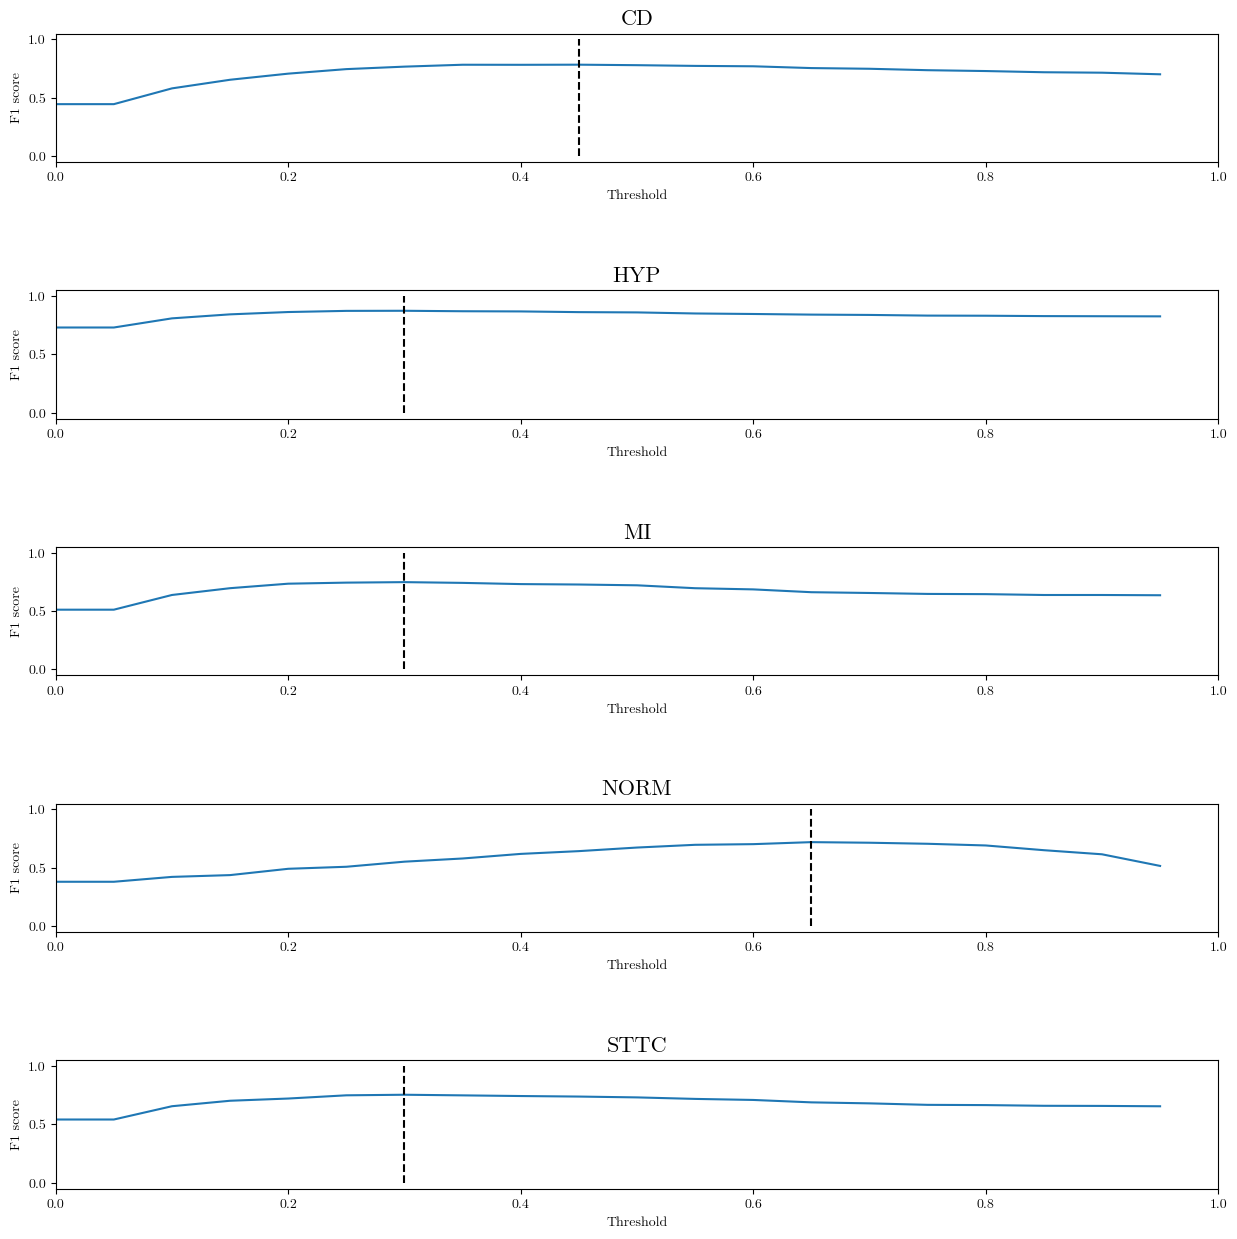

In [33]:
from scripts.data_evaluation import plot_optimal_thresholds

optimal_thresholds = plot_optimal_thresholds(
    y_test, y_pred_proba, directory_name="knn", save_plot=True
)

In [34]:
from scripts.data_evaluation import generate_model_evaluation

generate_model_evaluation(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    y_pred_proba=y_pred_proba,
    directory_name="knn",
    file_name="model_evaluation.csv",
    save_data=True,
)

,loss,binary_accuracy,recall,precision,auc
0,0.801,0.79,0.448,0.634,0.614


In [35]:
from scripts.data_evaluation import generate_model_evaluation

generate_model_evaluation(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    y_pred_proba=y_pred_proba,
    directory_name="knn",
    file_name="model_evaluation_optimized.csv",
    save_data=True,
)

,loss,binary_accuracy,recall,precision,auc
0,0.801,0.79,0.498,0.616,0.66


## Confusion matrix

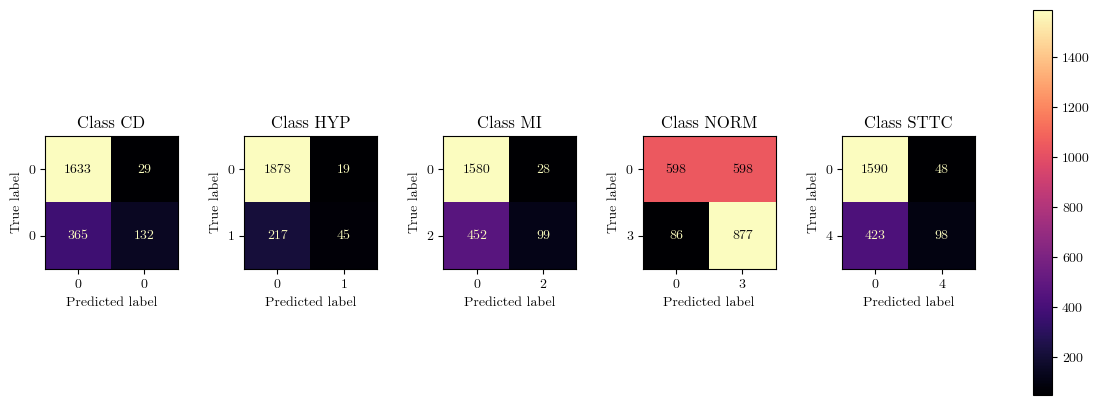

In [36]:
from scripts.data_evaluation import plot_confusion_matrix

plot_confusion_matrix(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    class_names=multi_label_binarizer.classes_,
    directory_name="knn",
    file_name="confusion_matrix.png",
    save_plot=True,
)

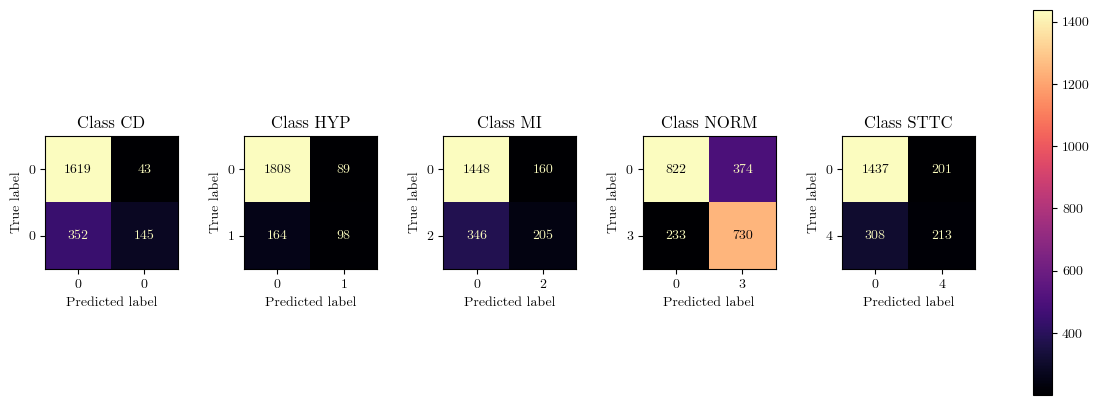

In [37]:
from scripts.data_evaluation import plot_confusion_matrix

plot_confusion_matrix(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    class_names=multi_label_binarizer.classes_,
    directory_name="knn",
    file_name="confusion_matrix_optimized.png",
    save_plot=True,
)

## Classification report

In [38]:
from scripts.data_evaluation import generate_classification_report

generate_classification_report(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    class_names=list(multi_label_binarizer.classes_),
    directory_name="knn",
    file_name="classification_report.csv",
    save_data=True,
)

,precision,recall,f1-score,support
CD,0.820,0.266,0.401,497.0
HYP,0.703,0.172,0.276,262.0
MI,0.780,0.180,0.292,551.0
NORM,0.595,0.911,0.719,963.0
STTC,0.671,0.188,0.294,521.0
micro avg,0.634,0.448,0.525,2794.0
macro avg,0.714,0.343,0.397,2794.0
weighted avg,0.696,0.448,0.458,2794.0
samples avg,0.541,0.502,0.513,2794.0


In [39]:
from scripts.data_evaluation import generate_classification_report

generate_classification_report(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    class_names=list(multi_label_binarizer.classes_),
    directory_name="knn",
    file_name="classification_report_optimized.csv",
    save_data=True,
)

,precision,recall,f1-score,support
CD,0.771,0.292,0.423,497.0
HYP,0.524,0.374,0.437,262.0
MI,0.562,0.372,0.448,551.0
NORM,0.661,0.758,0.706,963.0
STTC,0.514,0.409,0.456,521.0
micro avg,0.616,0.498,0.551,2794.0
macro avg,0.607,0.441,0.494,2794.0
weighted avg,0.621,0.498,0.533,2794.0
samples avg,0.529,0.521,0.512,2794.0


## Show predictions on sample patients

In [40]:
import pandas as pd
import numpy as np

number_of_patients = 15

sample_patients_predictions_df = pd.DataFrame()

for index in range(number_of_patients):
    patient_ecg = np.expand_dims(X_test[index], axis=0)
    patient_ecg_prob = (knn_model.predict_proba(patient_ecg).toarray() > 0.5) * 1
    sample_patients_predictions_df = pd.concat(
        [
            sample_patients_predictions_df,
            pd.DataFrame(
                data={
                    "Predicted": np.squeeze(patient_ecg_prob),
                    "True": y_test[index],
                    "---------": np.array(["-" for x in range(5)]),
                },
                index=list(multi_label_binarizer.classes_),
            ).transpose(),
        ]
    )

sample_patients_predictions_df.to_csv(f"saved_data/knn/sample_patients_predictions.csv")

sample_patients_predictions_df

,CD,HYP,MI,NORM,STTC
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0


In [41]:
import pandas as pd
import numpy as np

number_of_patients = 15

sample_patients_predictions_df = pd.DataFrame()

for index in range(number_of_patients):
    patient_ecg = np.expand_dims(X_test[index], axis=0)
    patient_ecg_prob = (
        knn_model.predict_proba(patient_ecg).toarray() > optimal_thresholds
    ) * 1
    sample_patients_predictions_df = pd.concat(
        [
            sample_patients_predictions_df,
            pd.DataFrame(
                data={
                    "Predicted": np.squeeze(patient_ecg_prob),
                    "True": y_test[index],
                    "---------": np.array(["-" for x in range(5)]),
                },
                index=list(multi_label_binarizer.classes_),
            ).transpose(),
        ]
    )

sample_patients_predictions_df.to_csv(
    f"saved_data/knn/sample_patients_predictions_optimized.csv"
)

sample_patients_predictions_df

,CD,HYP,MI,NORM,STTC
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0


## RandomForestClassifier

### Hyperparameter selection

In [39]:
from sklearn.ensemble import RandomForestClassifier

random_forest_parameters = [
    {
        "classifier": [RandomForestClassifier()],
        "classifier__n_estimators": [64, 100, 128, 200],
    },
]

random_forest_binary_relevance_classifier_cv = GridSearchCV(
    BinaryRelevance(),
    random_forest_parameters,
    verbose=2,
    scoring="accuracy",
    error_score="raise",
)

# Model training

In [40]:
random_forest_binary_relevance_classifier_cv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=64; total time=  45.2s
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=64; total time=  45.9s
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=64; total time=  45.9s
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=64; total time=  45.9s
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=64; total time=  46.8s
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=100; total time= 1.2min
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=100; total time= 1.2min
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=100; total time= 1.2min
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=100; total time= 1.2min
[CV] END classifier=RandomForestClassifier(), classifier__n_estimators=100; total time= 1.

GridSearchCV(error_score='raise',
             estimator=BinaryRelevance(require_dense=[True, True]),
             param_grid=[{'classifier': [RandomForestClassifier(n_estimators=200)],
                          'classifier__n_estimators': [64, 100, 128, 200]}],
             scoring='accuracy', verbose=2)

In [93]:
random_forest_binary_relevance_classifier_cv.best_params_

{'classifier': RandomForestClassifier(n_estimators=200),
 'classifier__n_estimators': 200}

### Model saving

In [94]:
import os
from joblib import dump

random_forest_model = random_forest_binary_relevance_classifier_cv.best_estimator_
random_forest_model_filename = "random_forest.joblib"
output_directory = f"saved_models/random_forest/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

random_forest_model_path = os.path.join(output_directory, random_forest_model_filename)

dump(
    value=random_forest_model,
    filename=random_forest_model_path,
)

['saved_models/random_forest/random_forest.joblib']

## Model loading

In [42]:
from joblib import load

random_forest_model = load("saved_models/random_forest/random_forest.joblib")

### Model evaluation

In [43]:
y_pred_proba = random_forest_model.predict_proba(X_test).toarray()

## Optimal thresholds

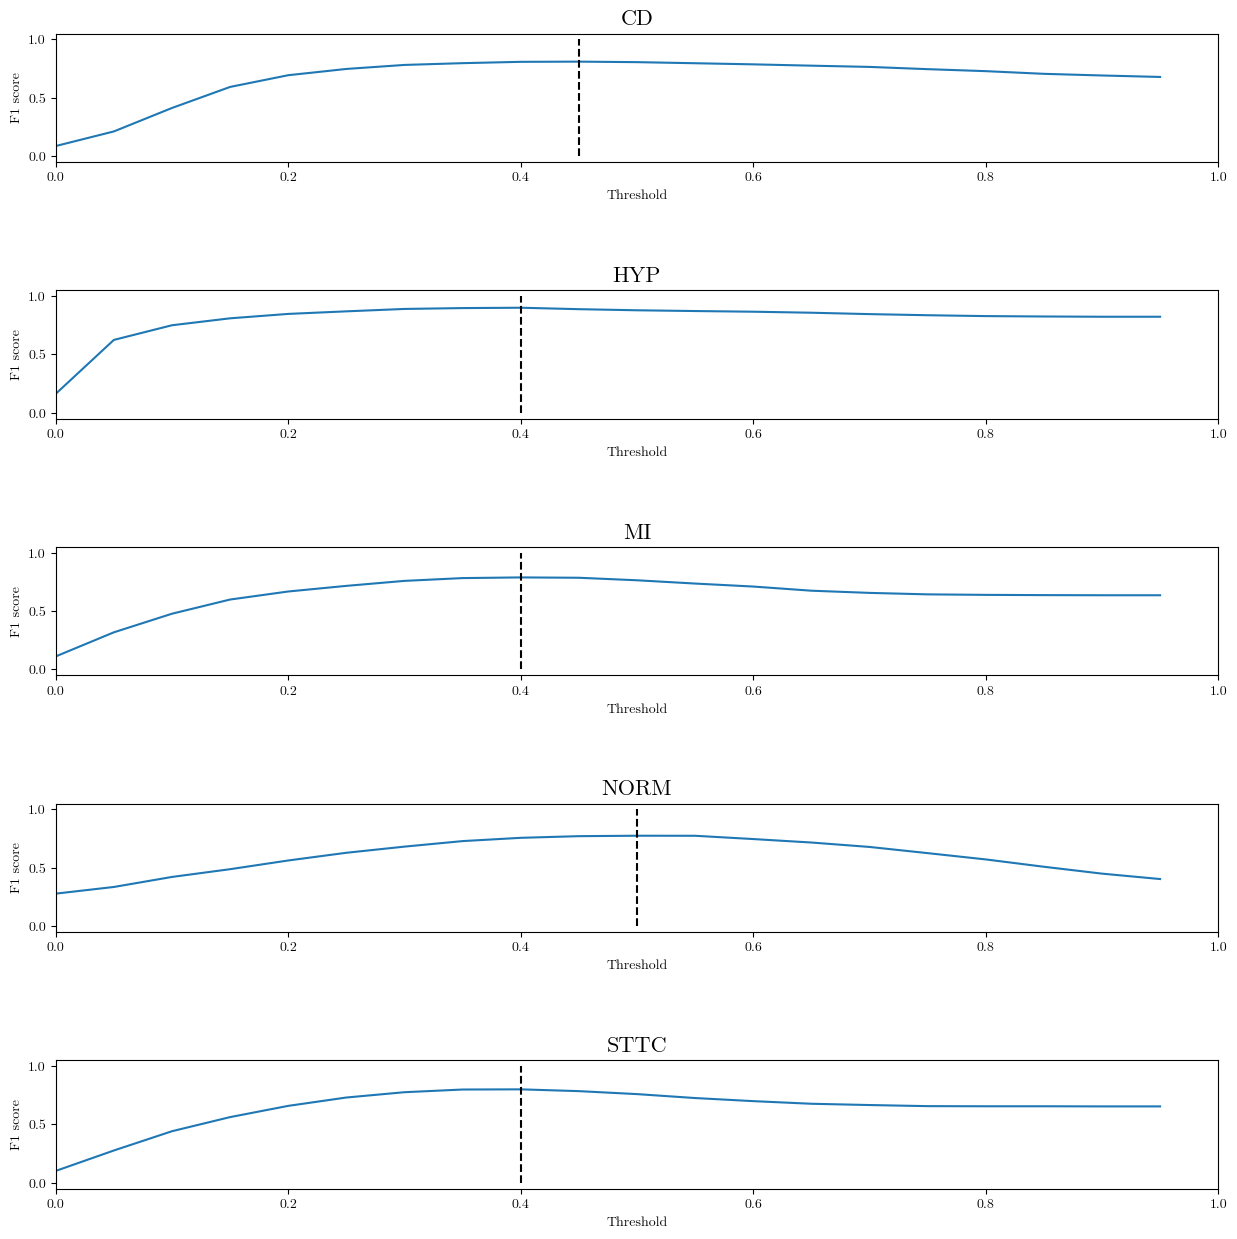

In [44]:
from scripts.data_evaluation import plot_optimal_thresholds

optimal_thresholds = plot_optimal_thresholds(
    y_test, y_pred_proba, directory_name="random_forest", save_plot=True
)

In [45]:
from scripts.data_evaluation import generate_model_evaluation

generate_model_evaluation(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    y_pred_proba=y_pred_proba,
    directory_name="random_forest",
    file_name="model_evaluation.csv",
    save_data=True,
)

,loss,binary_accuracy,recall,precision,auc
0,0.404,0.821,0.456,0.756,0.663


In [46]:
from scripts.data_evaluation import generate_model_evaluation

generate_model_evaluation(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    y_pred_proba=y_pred_proba,
    directory_name="random_forest",
    file_name="model_evaluation_optimized.csv",
    save_data=True,
)

,loss,binary_accuracy,recall,precision,auc
0,0.404,0.823,0.569,0.693,0.714


## Confusion matrix

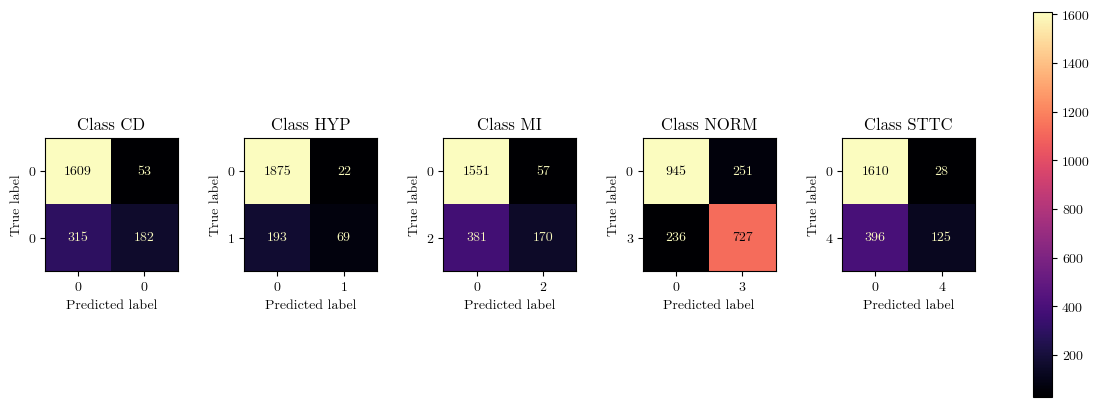

In [47]:
from scripts.data_evaluation import plot_confusion_matrix

plot_confusion_matrix(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    class_names=multi_label_binarizer.classes_,
    directory_name="random_forest",
    file_name="confusion_matrix.png",
    save_plot=True,
)

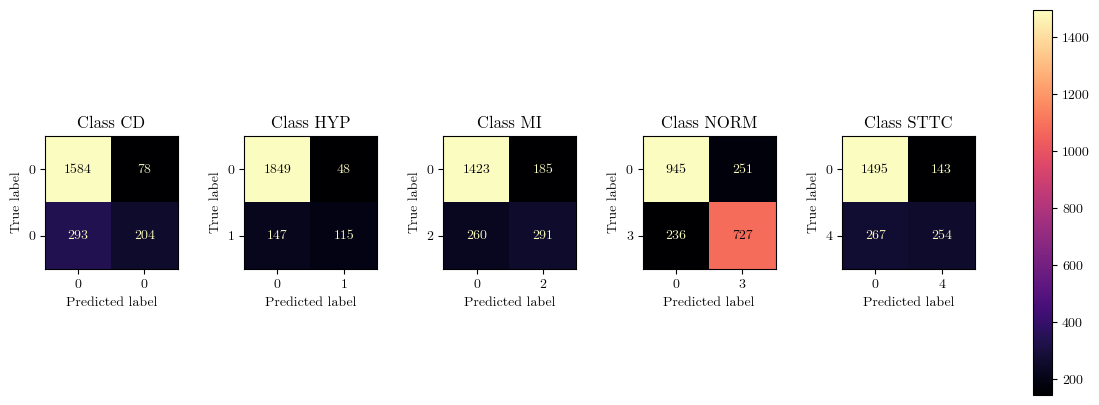

In [48]:
from scripts.data_evaluation import plot_confusion_matrix

plot_confusion_matrix(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    class_names=multi_label_binarizer.classes_,
    directory_name="random_forest",
    file_name="confusion_matrix_optimized.png",
    save_plot=True,
)

## Classification report

In [49]:
from scripts.data_evaluation import generate_classification_report

generate_classification_report(
    y_test=y_test,
    y_pred=(y_pred_proba > 0.5) * 1,
    class_names=list(multi_label_binarizer.classes_),
    directory_name="random_forest",
    file_name="classification_report.csv",
    save_data=True,
)

,precision,recall,f1-score,support
CD,0.774,0.366,0.497,497.0
HYP,0.758,0.263,0.391,262.0
MI,0.749,0.309,0.437,551.0
NORM,0.743,0.755,0.749,963.0
STTC,0.817,0.240,0.371,521.0
micro avg,0.756,0.456,0.569,2794.0
macro avg,0.768,0.387,0.489,2794.0
weighted avg,0.765,0.456,0.539,2794.0
samples avg,0.524,0.485,0.494,2794.0


In [50]:
from scripts.data_evaluation import generate_classification_report

generate_classification_report(
    y_test=y_test,
    y_pred=(y_pred_proba > optimal_thresholds) * 1,
    class_names=list(multi_label_binarizer.classes_),
    directory_name="random_forest",
    file_name="classification_report_optimized.csv",
    save_data=True,
)

,precision,recall,f1-score,support
CD,0.723,0.410,0.524,497.0
HYP,0.706,0.439,0.541,262.0
MI,0.611,0.528,0.567,551.0
NORM,0.743,0.755,0.749,963.0
STTC,0.640,0.488,0.553,521.0
micro avg,0.693,0.569,0.625,2794.0
macro avg,0.685,0.524,0.587,2794.0
weighted avg,0.691,0.569,0.617,2794.0
samples avg,0.577,0.578,0.564,2794.0


## Show predictions on sample patients

In [51]:
import pandas as pd
import numpy as np

number_of_patients = 15

sample_patients_predictions_df = pd.DataFrame()

for index in range(number_of_patients):
    patient_ecg = np.expand_dims(X_test[index], axis=0)
    patient_ecg_prob = (
        random_forest_model.predict_proba(patient_ecg).toarray() > 0.5
    ) * 1
    sample_patients_predictions_df = pd.concat(
        [
            sample_patients_predictions_df,
            pd.DataFrame(
                data={
                    "Predicted": np.squeeze(patient_ecg_prob),
                    "True": y_test[index],
                    "---------": np.array(["-" for x in range(5)]),
                },
                index=list(multi_label_binarizer.classes_),
            ).transpose(),
        ]
    )

sample_patients_predictions_df.to_csv(
    f"saved_data/random_forest/sample_patients_predictions.csv"
)

sample_patients_predictions_df

,CD,HYP,MI,NORM,STTC
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,0,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,0,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0


In [52]:
import pandas as pd
import numpy as np

number_of_patients = 15

sample_patients_predictions_df = pd.DataFrame()

for index in range(number_of_patients):
    patient_ecg = np.expand_dims(X_test[index], axis=0)
    patient_ecg_prob = (
        random_forest_model.predict_proba(patient_ecg).toarray() > optimal_thresholds
    ) * 1
    sample_patients_predictions_df = pd.concat(
        [
            sample_patients_predictions_df,
            pd.DataFrame(
                data={
                    "Predicted": np.squeeze(patient_ecg_prob),
                    "True": y_test[index],
                    "---------": np.array(["-" for x in range(5)]),
                },
                index=list(multi_label_binarizer.classes_),
            ).transpose(),
        ]
    )

sample_patients_predictions_df.to_csv(
    f"saved_data/random_forest/sample_patients_predictions_optimized.csv"
)

sample_patients_predictions_df

,CD,HYP,MI,NORM,STTC
Predicted,0,0,0,1,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,0,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,0,0
True,0,0,0,1,0
---------,-,-,-,-,-
Predicted,0,0,0,1,0
